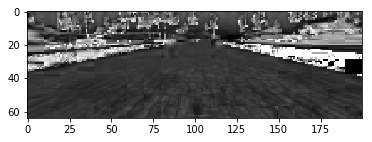

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from math import floor, ceil
import numpy as np
%matplotlib inline

#Load driving log:

driving_log = pd.read_csv(
    'driving_log.csv',
    names = ['Center','Left','Right','Steering Angle','Throttle','Break','Speed'],
    header = None,
    skiprows = 1)

#Load and preprocess images:

def load_image(path, flip=False):
    image = cv2.imread(path)
    #Crop image, remove sky (upper 20%) and the bottom part (%12). Leave some of both for bumpy sections.
    image = image[floor(image.shape[0]*0.2):floor(image.shape[0]*0.88),:,:]
    #Resize image to the model's expected input shape
    image = cv2.resize(image, (200, 64)) 
    #Change color space to HSV and pick the S channel   
    image = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    image = image[:,:,1]    
    
    #Flip image
    if flip:
        image = cv2.flip(image, 1)
    
    return image

#Show first image
image = load_image(driving_log['Center'][0].strip(), True)
plt.figure()
plt.imshow(image, cmap='gray')


In [2]:
#Set aside 1000 images for validation purposes
val_index_list = []
val_set_size = 1000
counter = 0
while counter < val_set_size:
    temp_idx = np.random.randint(driving_log.shape[0])
    if temp_idx not in val_index_list:
        val_index_list.append(temp_idx)
        counter += 1

In [3]:
def generator_train(data, batch_size = 100):
    
    while True:    
    
        X_Train_list, Y_Train_list = [], []
        counter = 0
        while counter < batch_size:
            idx = np.random.randint(len(data))
            #Half the time we'll skip image if angle == 0.0. We do this in order 
            #to rebalance the dataset, as more than half of the images have 
            #a steering angle of 0.0. We'll also skip images in the validation set.
            if idx in val_index_list or (data['Steering Angle'][idx] == 0.0 and np.random.randint(2) == 0):                
                continue
            else:
                #Each camera image has a probability of 33% of being chosen
                #For the left and right camera, the steering angle needs to be
                #compensated (+0.25/-0.25)
                image_choice = np.random.randint(3)
                if image_choice == 0:
                    X_Train_list.append(data['Center'][idx])
                    Y_Train_list.append(data['Steering Angle'][idx])
                elif image_choice == 1:
                    X_Train_list.append(data['Left'][idx])
                    Y_Train_list.append(data['Steering Angle'][idx] +.25)
                else:
                    X_Train_list.append(data['Right'][idx])
                    Y_Train_list.append(data['Steering Angle'][idx] -.25)
        
                counter += 1

        X_Train_regular = [load_image(path.strip()) for path in X_Train_list[0:ceil(batch_size/2.0)]]        
        Y_Train_regular = [angle for angle in Y_Train_list[0:ceil(batch_size/2.0)]]
        
        #We'll flip half the batch
        X_Train_flipped = [load_image(path.strip(), True) for path in X_Train_list[ceil(batch_size/2.0):]]
        Y_Train_flipped = [-angle for angle in Y_Train_list[ceil(batch_size/2.0):]
                          ]
        X_Train = np.array(X_Train_regular + X_Train_flipped)
        Y_Train = np.array(Y_Train_regular + Y_Train_flipped)
        
        #This reshape operation is needed for the input, which is just one channel,
        #to have the proper dimension for the convolution layers
        X_Train = X_Train.reshape(X_Train.shape[0], 64, 200, 1)
                
        yield X_Train, Y_Train

In [4]:
def generator_val(data, batch_size = 100):
    while True:        
        X_Val_list, Y_Val_list = [], []
        idx = 0
        
        for counter in range(batch_size):
            X_Val_list.append(data['Center'][val_index_list[idx]])
            Y_Val_list.append(data['Steering Angle'][val_index_list[idx]])
            idx += 1
        
        X_Val = np.array([load_image(path.strip()) for path in X_Val_list])
        Y_Val = np.array([angle for angle in Y_Val_list])
        
        #This reshape operation is needed for the input, which is just one channel,
        #to have the proper dimension for the convolution layers        
        X_Val = X_Val.reshape(X_Val.shape[0], 64, 200, 1)
        
        yield X_Val, Y_Val

In [5]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Lambda
from keras.layers import Convolution2D, Flatten

def nvidia_dnn():
    
    input_shape = (64, 200, 1)
    model = Sequential()
    
    #Scale images pixel values between -0.5 and 0.5
    model.add(Lambda(lambda x:x/255.-.5, input_shape = input_shape))    
    
    model.add(Convolution2D(24, 5, 5, init = 'normal', border_mode='valid', subsample = (2, 2), name = 'conv1', input_shape = input_shape))
    model.add(Activation('relu'))
    
    model.add(Convolution2D(36, 5, 5, init = 'normal', border_mode='valid', subsample = (2, 2), name = 'conv2'))
    model.add(Activation('relu'))

    model.add(Convolution2D(48, 5, 5, init = 'normal', border_mode='valid', subsample = (2, 2), name = 'conv3'))
    model.add(Activation('relu'))

    model.add(Convolution2D(64, 3, 3, init = 'normal', border_mode='valid', subsample = (1, 1), name = 'conv4'))
    model.add(Activation('relu'))
    
    model.add(Convolution2D(64, 3, 3, init = 'normal', border_mode='valid', subsample = (1, 1), name = 'conv5'))
    model.add(Activation('relu'))
    
    model.add(Flatten())
    model.add(Dense(1164, init = 'normal', name = 'dense1'))
    model.add(Activation('relu'))
    
    model.add(Dense(100, init = 'normal', name = 'dense2'))
    model.add(Activation('relu'))
    
    model.add(Dense(50, init = 'normal', name = 'dense3'))
    model.add(Activation('relu'))
    
    model.add(Dense(1, init = 'normal', name = 'dense4'))
    model.compile(optimizer = 'Adam', loss = 'mse')
    
    return model

Using TensorFlow backend.


In [6]:
model = nvidia_dnn()

train_generator = generator_train(driving_log, batch_size = 50)
val_generator = generator_val(driving_log, batch_size = 50)

samples_per_epoch = 24000
nb_val_samples = 1000

history = model.fit_generator(
    train_generator, 
    samples_per_epoch = samples_per_epoch, 
    nb_epoch = 1,
    validation_data = val_generator,
    nb_val_samples = nb_val_samples)

from pathlib import Path
import os

filename = 'model.h5' 
if Path(filename).is_file():
    os.remove(filename)
model.save(filename)

Epoch 1/1
24000/24000 [==============================] - 51s - loss: 0.0260 - val_loss: 0.0268